In [1]:
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy import interpolate
import pickle
# import emcee

import xmeos
from xmeos import models
from xmeos import datamod

In [2]:
analysis_file = 'data/analysis.pkl'
with open(analysis_file, 'rb') as f:
    analysis = pickle.load(f)

In [3]:
eos_mod = analysis['eos_mod']
data = analysis['datasets']['Spera2011']
param_tex_str = analysis['param_tex_str']
params_init = analysis['params_init']

eos_mod.set_params(params_init)
# display(eos_mod.get_params())
datamodel = datamod.init_datamodel(data, eos_mod)


In [4]:
print('Calc Params')
print('===========')
eos_mod.get_calc_params()

Calc Params


{'bcoef': ['_bcoef_0', '_bcoef_1', '_bcoef_2', '_bcoef_3', '_bcoef_4', 'V0'],
 'compress': ['V0', 'K0', 'KP0'],
 'gamma': ['V0', 'gamma0', 'gammap0'],
 'refstate': ['V0', 'S0', 'E0'],
 'thermal': ['mexp', 'Cvlimfac']}

In [5]:
fit_calcs = ['compress','refstate','gamma','bcoef','thermal']
fix_params = ['S0','Cvlimfac','mexp']
# fix_params = ['S0','mexp']
datamodel['eos_mod'].set_param_values([3/5,1], param_names=['mexp','Cvlimfac'])
datamod.select_fit_params(datamodel, fit_calcs, fix_params=fix_params)
# datamodel['fit_params']

['V0',
 'K0',
 'KP0',
 'E0',
 'gamma0',
 'gammap0',
 '_bcoef_0',
 '_bcoef_1',
 '_bcoef_2',
 '_bcoef_3',
 '_bcoef_4']

In [6]:
datamod.fit(datamodel)
datamod.fit(datamodel, apply_bulk_mod_wt=True)

In [7]:
display('R2fit = ', datamodel['posterior']['R2fit'])
display('Model Residual Error = ', datamodel['posterior']['fit_err'])
display(datamodel['posterior']['param_tbl'])

'R2fit = '

{'E': 0.9996791067319023, 'P': 0.99958058608458344, 'V': 0.99892700507917565}

'Model Residual Error = '

{'E': 0.006764450234484555, 'P': 1.2504009064578745, 'V': 0.091349229681378388}

,name,value,error
0,V0,12.996831,0.015967
1,K0,12.904643,0.177647
2,KP0,8.224677,0.052797
3,E0,-20.597673,0.002181
4,gamma0,0.203436,0.005481
5,gammap0,-1.819966,0.040046
6,_bcoef_0,0.978286,0.010981
7,_bcoef_1,0.366087,0.067279
8,_bcoef_2,1.184379,0.240993
9,_bcoef_3,0.644150,1.771230


In [12]:
from collections import OrderedDict
CONSTS = models.CONSTS

natom=5
Vconv = CONSTS['ang3percc']/natom/CONSTS['Nmol'] # (ang^3/atom) / (cc/mol)

eos_mod = datamodel['eos_mod']
Tref = 1773
Vref = eos_mod.volume(0,Tref)
refvals = OrderedDict()
refvals['Vref'] = Vref/Vconv
refvals['Kref'] = eos_mod.bulk_modulus(Vref,Tref)
refvals['Cvref'] = eos_mod.heat_capacity(Vref,Tref)/CONSTS['kboltz']
display(refvals)

OrderedDict([('Vref', array([ 35.41102292])),
             ('Kref', array([ 13.95838826])),
             ('Cvref', array([ 4.23190795]))])

In [8]:
# Save fitted model
analysis['datamodel'] = datamodel
with open(analysis_file, 'wb') as f:
    pickle.dump(analysis, f)

<IPython.core.display.Javascript object>


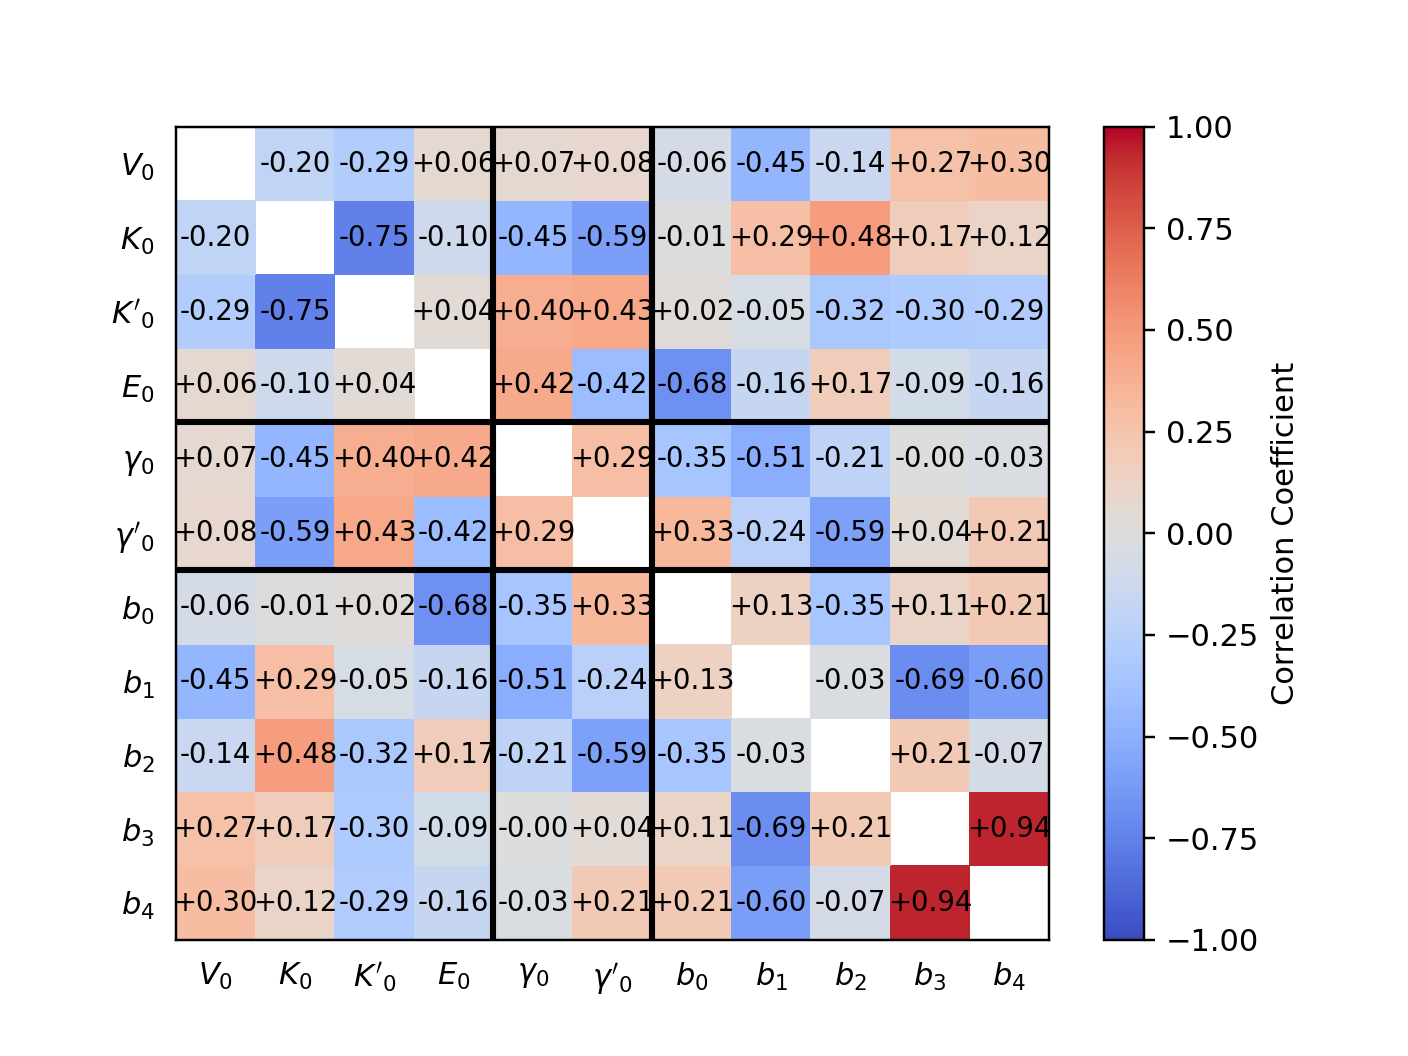

In [10]:
posterior = datamodel['posterior']
corr = posterior['corr']

param_labels = [param_tex_str[name] for name in posterior['param_names']]


cmap = plt.get_cmap('coolwarm')
Nparam = len(param_labels)

corr_plt = np.flipud(np.ma.masked_where(np.eye(Nparam),corr))
plt.pcolormesh(corr_plt,cmap=cmap)


# plt.imshow(corr, cmap=cmap)
plt.clim(-1,1)
plt.colorbar(label=r'Correlation Coefficient')

plt.xticks(.5+np.arange(len(param_labels)),param_labels)
plt.yticks(np.flipud(.5+np.arange(len(param_labels))),param_labels)

for (index,val) in np.ndenumerate(np.flipud(corr)):
    if index[1]!=Nparam-1-index[0]:
        plt.text(index[1]+.5,index[0]+.5,'%+.2f'%(val),fontsize=9,
                 horizontalalignment='center', verticalalignment='center')

plt.setp(plt.gca().get_xticklines(),visible=False)
plt.setp(plt.gca().get_yticklines(),visible=False)

plt.plot((0,11),(5,5),'k-',linewidth=2)
plt.plot((0,11),(7,7),'k-',linewidth=2)
plt.plot((4,4),(0,11),'k-',linewidth=2)
plt.plot((6,6),(0,11),'k-',linewidth=2)
plt.show()



In [11]:
eos_mod = datamodel['eos_mod']
V0 = eos_mod.get_params()['V0']
tbl = datamodel['data']['table']
Tlbl = data['T_labels']
delT = Tlbl[1]-Tlbl[0]

cmap = plt.get_cmap('coolwarm',len(Tlbl))
clims = [Tlbl[0]-delT/2,Tlbl[-1]+delT/2]

Vmod = V0*np.linspace(.4,1.1,1001)

<IPython.core.display.Javascript object>


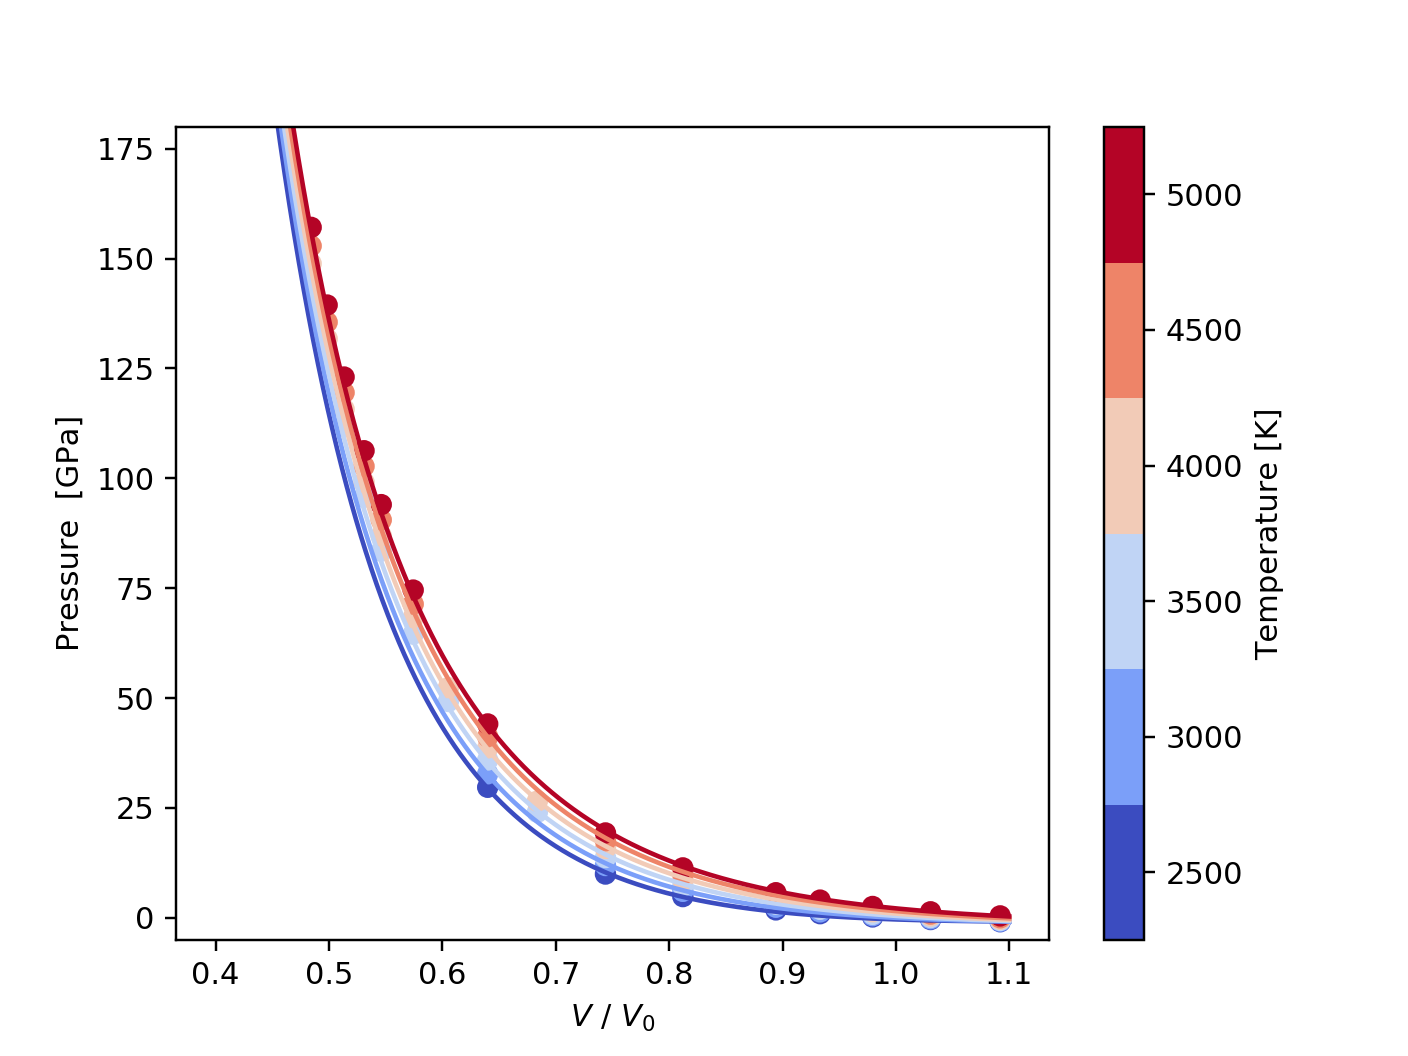

(-5, 180)

In [12]:
plt.figure()
for iT in Tlbl:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod/V0, eos_mod.press(Vmod,iT), '-', color=icol)
    
plt.scatter(tbl['V']/V0,tbl['P'],c=tbl['T'], cmap=cmap)
plt.clim(clims)
plt.xlabel(r'$V$ / $V_0$')
plt.ylabel(r'Pressure  [GPa]')
cbar = plt.colorbar(label='Temperature [K]')
cbar.set_ticks(Tlbl)

plt.ylim(-5,180)



<IPython.core.display.Javascript object>


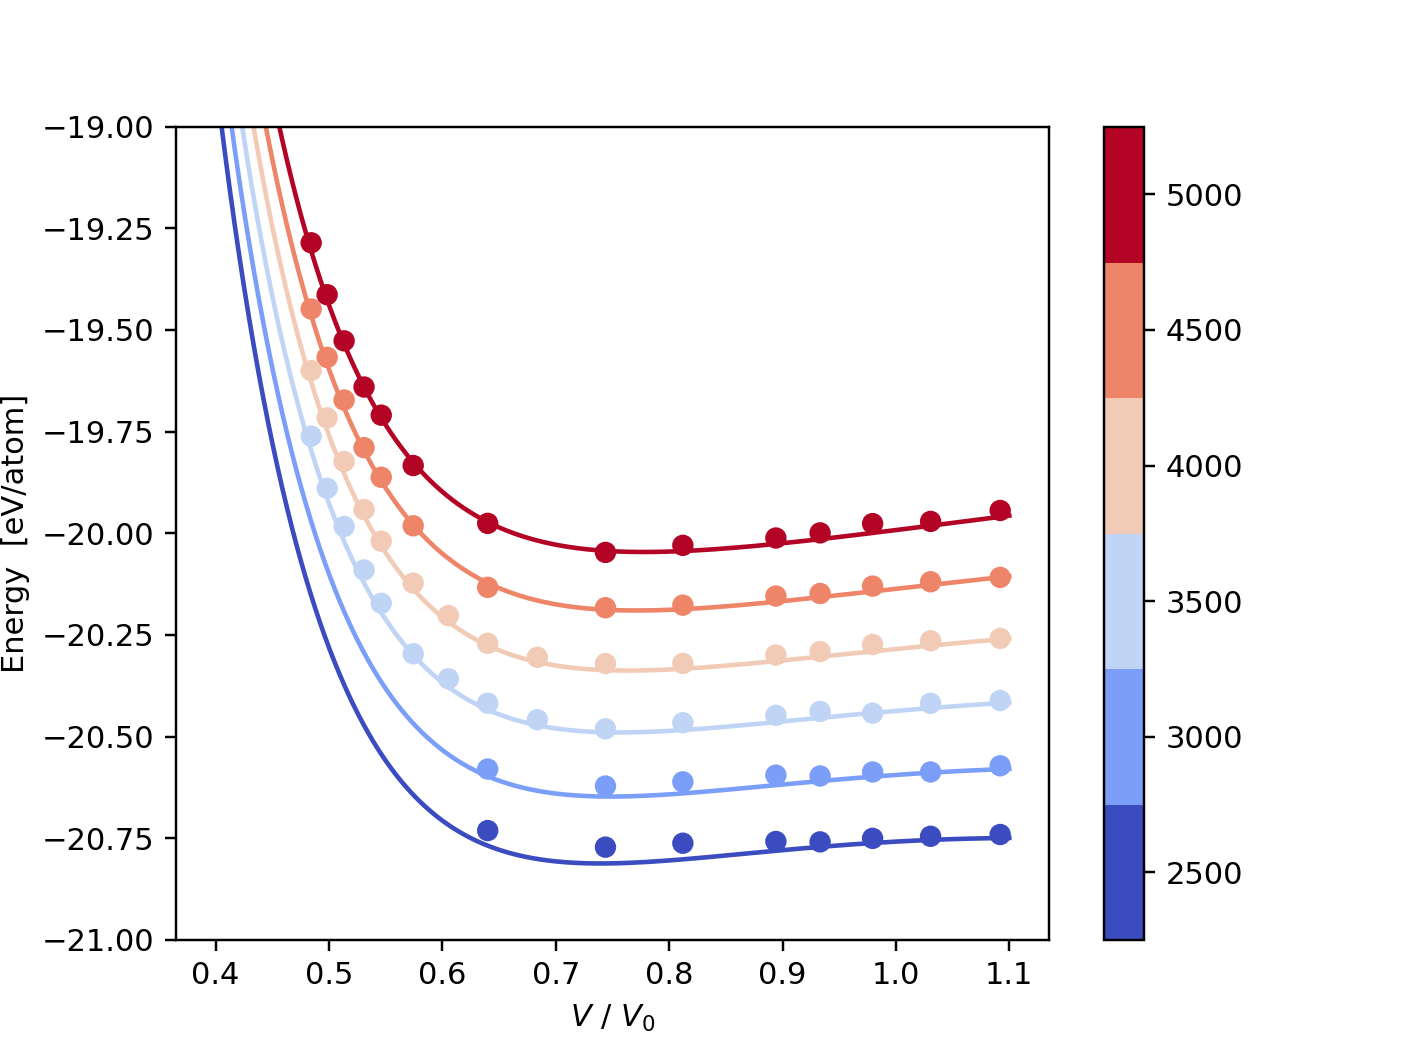

(-21, -19)

In [13]:
plt.figure()
for iT in Tlbl:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod/V0, eos_mod.internal_energy(Vmod,iT), '-', color=icol)
    
plt.scatter(tbl['V']/V0,tbl['E'],c=tbl['T'], cmap=cmap)
plt.xlabel(r'$V$ / $V_0$')
plt.ylabel(r'Energy  [eV/atom]')
cbar = plt.colorbar()
plt.clim(clims)
cbar.set_ticks(Tlbl)
plt.ylim(-21,-19)

<IPython.core.display.Javascript object>


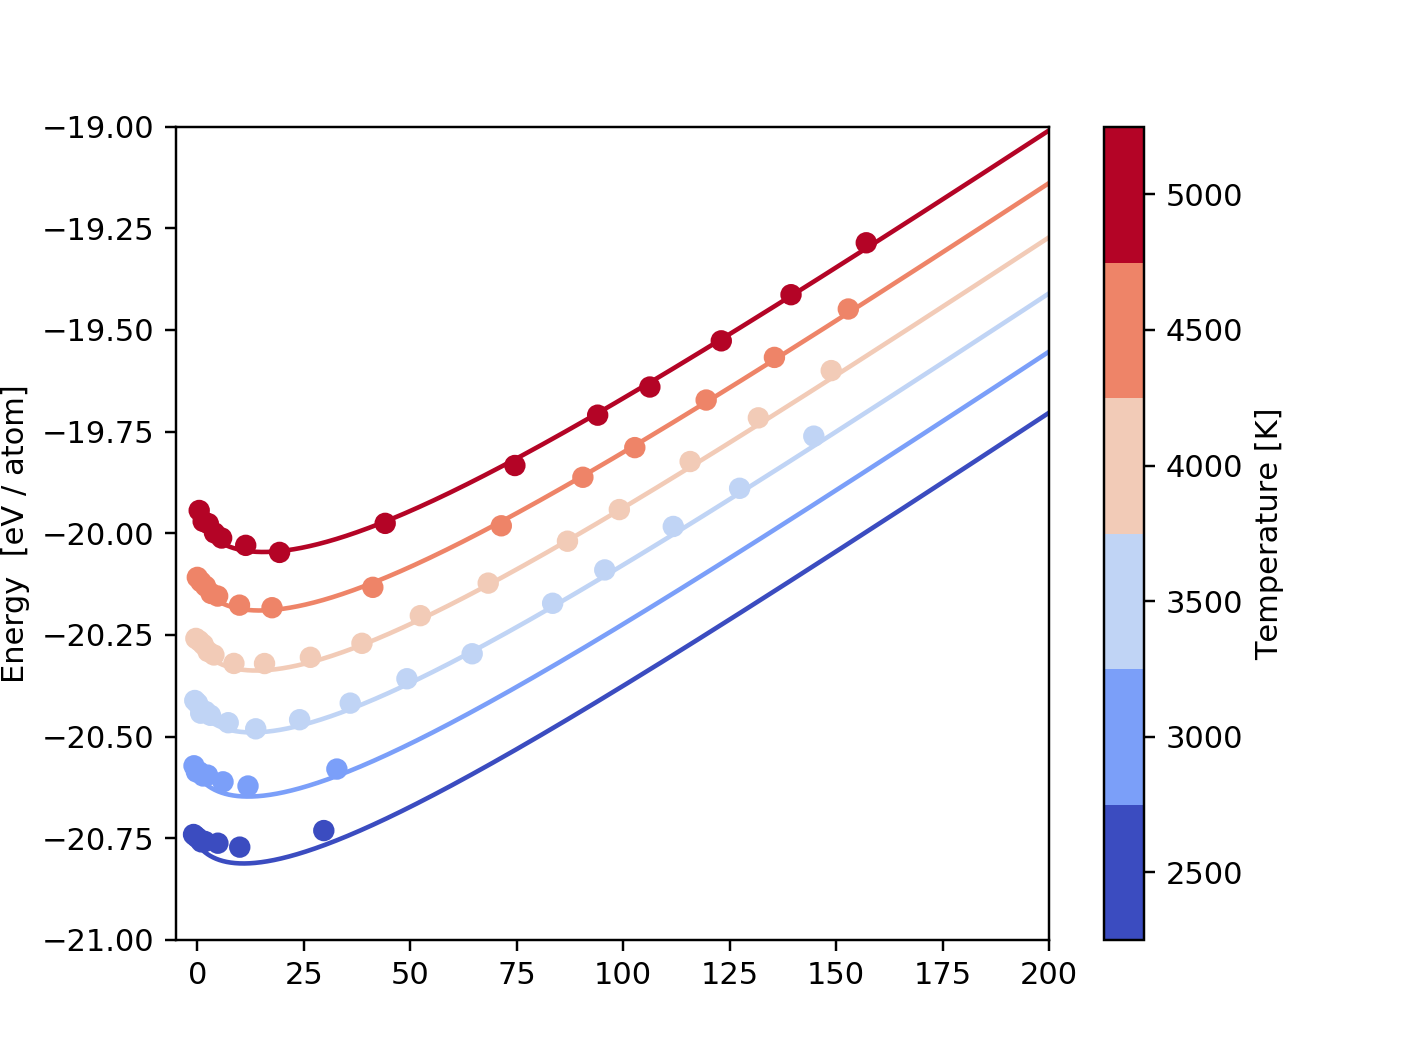

(-21, -19)

In [14]:
plt.figure()
for iT in Tlbl:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(eos_mod.press(Vmod,iT), eos_mod.internal_energy(Vmod,iT), '-', color=icol)
    
plt.scatter(tbl['P'], tbl['E'], c=tbl['T'], cmap=cmap)
plt.clim(clims)
plt.ylabel(r'Pressure  [GPa]')
plt.ylabel(r'Energy  [eV / atom]')
cbar = plt.colorbar(label='Temperature [K]')
cbar.set_ticks(Tlbl)

plt.xlim(-5, 200)
plt.ylim(-21, -19)